### **Convolutional Neural Networks, and Large Scale Visual Recognition Project**
<em>University of Virginia - Introduction to Computer Vision - Fall 2019 - Vicente Ordonez - vicente@virginia.edu</em><br/><br/>

In this assignment we will apply our knowledge of machine learning and visual recognition using convolutional neural networks to detect various kinds of things from images. 



#### **1. Pytorch on the GPU**
As we deal with increasingly complex models, and larger datasets and image resolutions, we need to be efficient in computing matrix multiplications. In this section we will experiment with GPU computations and how they speed up some computations under certain conditions. Now we are going to test the GPU environment in a task of multiplying two square matrices of size $d\times d$. We provide code below sample code and output for this part but you need to complete the test below.

In [2]:
import torch
import time

# Let's create two matrices of size 4x4 and full of ones.
d = 4000
a = torch.rand(d, d)
b = torch.rand(d, d)

# Compute a dot product between the two matrices in CPU.
start_time = time.time()
output = torch.mm(a,b)  # Regular multiplication in CPU.
cpu_time = time.time() - start_time
print('CPU-time {0:.6f}s'.format(cpu_time))

# Compute a dot product between the two matrices in GPU.
start_time = time.time()
a = a.cuda() # Move to GPU.
b = b.cuda() # Move to GPU.
output = torch.mm(a,b)  # Multiplication happens in GPU.
gpu_time = time.time() - start_time
print('GPU-time {0:.6f}s\n'.format(gpu_time))

print('CPU was {0:.2f}x times the GPU time'.format(cpu_time / gpu_time))

CPU-time 1.800874s
GPU-time 5.875390s

CPU was 0.31x times the GPU time


**Final Comments:** In the GPU code there is a more or less fixed cost of moving tensors to the GPU, this causes using GPUs slower for small tensors counter-productive. Try timing this separately and estimate the cost of this move. Most functions in pytorch have a CUDA implementation so just by moving tensors to the GPU using .cuda() you can perform any operation in a highly parallel manner on a GPU. Moreover, Pytorch supports parallelization on multiple GPUs as well.<br/><br/>

#### **2. Convolutional Neural Networks**
This section will build on the previous project but now we will use a convolutional neural network to obtain higher accuracies.

##### **2.1 CIFAR-10 Data Loading**
In this section we will load the CIFAR-10 dataset, a dataset with 50 thousand training images of size 3x32x32 each belonging to one out of 10 possible categories of objects. First, let's download a local copy from the CS server.

In [18]:
import matplotlib.pyplot as plt
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
# This is a convenient data reader.
categories = ['airplane', 'automobile', 'bird', 'cat', 'deer',
              'dog', 'frog', 'horse', 'ship', 'truck']
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), 
                         (0.2023, 0.1994, 0.2010))
])
batch_size = 128
train_data = datasets.CIFAR10(root = './datalab', train = True, download = True, transform = preprocess)
trainLoader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          shuffle=True, num_workers=0)
validation_data = datasets.CIFAR10(root='./datalab', train = False, transform = preprocess)
valLoader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size,
                                         shuffle=False, num_workers=0)

Files already downloaded and verified


##### **2.2 Convolutional Neural Network classifier**
In this section, you will define a convolutional neural network classifier and compute the accuracy of the model on CIFAR-10. Feel free to create any network that you consider would work well. You can get inspiration in some of the convolutional neural network architectures studied in class. I recommend you start with the LeNet architecture included below and start from there.

In [0]:
# Defining the model.
from tqdm import tqdm as tqdm
import torch.nn as nn
import torch.optim as optim

# LeNet is French for The Network, and is taken from Yann Lecun's 1998 paper
# on digit classification http://yann.lecun.com/exdb/lenet/
# This was also a network with just two convolutional layers.
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        
        # Convolutional layers.
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        # Linear layers.
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Conv1 + ReLU + MaxPooling.
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        
        # Conv2 + ReLU + MaPooling.
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        
        # This flattens the output of the previous layer into a vector.
        out = out.view(out.size(0), -1) 
        # Linear layer + ReLU.
        out = F.relu(self.fc1(out))
        # Another linear layer + ReLU.
        out = F.relu(self.fc2(out))
        # A final linear layer at the end.
        out = self.fc3(out)
       
        # We will not add nn.LogSoftmax here because nn.CrossEntropy has it.
        # Read the documentation for nn.CrossEntropy.
        return out
        
class AlexNet(nn.Module):

    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x        
# Definition of our network.
classifier = LeNet()

#Definition of our loss.
criterion = nn.CrossEntropyLoss()
learningRate = 0.001
# Definition of optimization strategy.
# This optimizer has access to all the parameters in the model.
#
# It can zero all the parameters by doing:
#                                  optimizer.zero_grad()
#
# It can perform an SGD optimization update step in the direction of
# the gradients for each parameters by doing:
#                                  optimizer.step()
#
optimizer = optim.SGD(classifier.parameters(), lr = learningRate)


#### **3. Deep Convolutional Neural Networks**
In this section we will use a state-of-the-art deep neural network trained on the ILSVRC (Imagenet Large Scale Visual Recognition Challenge) dataset.




In this section we will experiment with a ResNet network with 50 layers of depth as seen during class. This network was trained in the ILSVRC task where it was trained on a million images each with one label belonging to 1000 possible classes. First let's load the pre-trained model that comes with Pytorch and categories vocabulary.

In [13]:
import torchvision.models as models

# Download list of 1000 categories for the ILSVRC task in right order.
!wget -nc http://www.cs.virginia.edu/~vicente/vision/imagenet_class_index.json
  
# Load the pre-trained model from the torchvision package.
resnet = models.resnet50(pretrained = True);
resnet.eval();  # Set in evaluation mode! In this case it matters.

File ‘imagenet_class_index.json’ already there; not retrieving.



Now let's run an image through the network. Pay careful attention to all the steps.

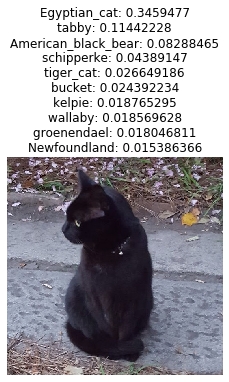

In [14]:
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.models as models
import json, io, requests, string
import torch.nn.functional as F
import torch

# 1. Define the appropriate image pre-processing function.
# This depends on the preprocessing function used during training. 
preprocessFn = transforms.Compose(
    [transforms.Resize(256), 
     transforms.CenterCrop(224), 
     transforms.ToTensor(), 
     transforms.Normalize(mean = [0.485, 0.456, 0.406], 
                          std = [0.229, 0.224, 0.225])])

# 2. Load the imagenet class names.
imagenetClasses = {int(idx): entry[1] for (idx, entry) in 
                   json.load(open('imagenet_class_index.json')).items()}


# 3. Read image from URL into a PIL image type.
img_url = 'http://www.cs.virginia.edu/~vicente/vision/black-cat.jpg'
response = requests.get(img_url)
img_pil = Image.open(io.BytesIO(response.content))

# 4. Forward propagate the image through the CNN.
# Unsqueeze adds a dummy batch dimension needed to pass through the model.
inputVar =  preprocessFn(img_pil).unsqueeze(0)
predictions = resnet(inputVar)

# 5. Decode the top 10 classes predicted for this image.
# We need to apply softmax because the model outputs the last linear layer
# outputs and not softmax scores.
probs, indices = (-F.softmax(predictions, dim = 1).data).sort()
probs = (-probs).numpy()[0][:10]; indices = indices.numpy()[0][:10]
preds = [imagenetClasses[idx] + ': ' + str(prob) for (prob, idx) in zip(probs, indices)]

# 6. Show image and predictions
plt.title('\n'.join(preds))
plt.imshow(img_pil); plt.grid('off'); plt.axis('off');

### **Assignment Questions** (10pts)


#### **1. GPU Benchmarking** (1pts)
From the example code given in section 1, produce a plot using matplotlib that shows the execution time (y-axis) versus the size $d$ of the square matrices (x-axis) for both GPU and CPU (use values of $d$ = [10, 100, 1000, 5000, 10000]). Answer the following question: For what values of $d$ would you recommend using a GPU?

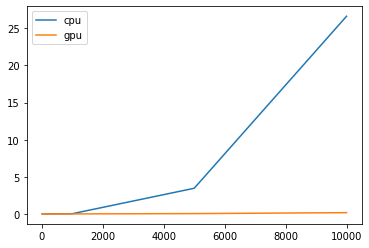

In [13]:

import torch
import time
import matplotlib.pyplot as plt
import numpy as np
d = [10, 100, 1000, 5000, 10000]

cpu = []
gpu = []

for i in d:
  a = torch.rand(i, i)
  b = torch.rand(i, i)

  start_time = time.time()
  output = torch.mm(a,b)  # Regular multiplication in CPU.
  cpu_time = time.time() - start_time
  cpu.append(cpu_time)

  start_time = time.time()
  a = a.cuda() # Move to GPU.
  b = b.cuda() # Move to GPU.
  output = torch.mm(a,b)  # Multiplication happens in GPU.
  gpu_time = time.time() - start_time
  gpu.append(gpu_time)

plt.plot(d, cpu)
plt.plot(d, gpu)
plt.legend(['cpu', 'gpu'], loc='upper left')

plt.show()

#### **2. Train a Modified version of LeNet on CIFAR-10** (3pts)
Propose and train a modified version of the LeNet CNN defined in this notebook on the CIFAR-10 dataset and compute the accuracy. Plot the loss for training and validation as training progresses (same as in the previous assignment), and the accuracy for training and validation (same as in the previous assignment). What is the final accuracy? Hints: Remember to use classifier.train() classifier.eval(), also remember to normalize the input data. Also, use the GPU.

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)
classifier.train()
classifier.to(device)


cuda:0


LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [19]:
epochs = []
train_loss = []
valid_loss = []
train_accuracy = []
valid_accuracy = []
def train_model(classifier, criterion, optimizer, 
                trainLoader, valLoader, n_epochs = 10):

  for epoch in range(n_epochs):  # loop over the dataset multiple times
      correct = 0
      cumloss = 0
      n = 0
      for i, data in enumerate(trainLoader, 0):
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data[0].to(device), data[1].to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = classifier(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          with torch.no_grad():
            _, max_labels = outputs.max(1)
            correct += (max_labels == labels).sum().item() 
            cumloss += loss.item()
            n += 1
      n = len(train_data)
      print('({0}) Training: loss = {1:.4f}, accuracy = {2:.4f}'
        .format(epoch, cumloss / n, correct / n))
      train_loss.append(cumloss / n)
      train_accuracy.append(correct / n)
      
      correct = 0
      cumloss = 0
      n = 0
      with torch.no_grad():
        for i, data in enumerate(valLoader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)
            # zero the parameter gradients

            # forward + backward + optimize
            outputs = classifier(inputs)
            _, max_labels = outputs.max(1)
            correct += (max_labels == labels).sum().item() 
            cumloss += loss.item()
      n = len(validation_data)
      print('({0}) Validation: loss = {1:.4f}, accuracy = {2:.4f}'
        .format(epoch, cumloss / n, correct / n))
      epochs.append(epoch+1)
      valid_loss.append(cumloss / n)
      valid_accuracy.append(correct / n)

train_model(classifier, criterion, optimizer, 
           trainLoader, valLoader, n_epochs = 10)

import numpy as np

x = epochs

plt.plot(x, train_loss)
plt.plot(x, valid_loss)
plt.legend(['train_loss', 'valid_loss'], loc='upper left')

plt.show()


plt.plot(x, train_accuracy)
plt.plot(x, valid_accuracy)
plt.legend(['train_accuracy', 'valid_accuracy'], loc='upper left')

plt.show()

(0) Training: loss = 0.0180, accuracy = 0.1002
(0) Validation: loss = 0.0181, accuracy = 0.1010
(1) Training: loss = 0.0180, accuracy = 0.1011
(1) Validation: loss = 0.0181, accuracy = 0.1027


KeyboardInterrupt: ignored

**Final Comments:** You should get a much better classification accuracy of this model. Try running it in some validation images and see how much better are the predictions of this model compared to the one used in a previous assignment.

#### **3. Use Resnet to make some predictions** (2pts)

Take pictures of two objects for which the ResNet network trained on ILSVRC works really well and show the predictions, do the same for two objects for which the network doesn't do well. Take your own pictures of objects at your place, don't download images from the internet.

In [20]:
import torchvision.models as models

# Download list of 1000 categories for the ILSVRC task in right order.
!wget -nc http://www.cs.virginia.edu/~vicente/vision/imagenet_class_index.json
  
# Load the pre-trained model from the torchvision package.
resnet = models.resnet50(pretrained = True);
resnet.eval();  # Set in evaluation mode! In this case it matters.

File ‘imagenet_class_index.json’ already there; not retrieving.



In [0]:
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.models as models
import json, io, requests, string
import torch.nn.functional as F
import torch

# 1. Define the appropriate image pre-processing function.
# This depends on the preprocessing function used during training. 
preprocessFn = transforms.Compose(
    [transforms.Resize(256), 
     transforms.CenterCrop(224), 
     transforms.ToTensor(), 
     transforms.Normalize(mean = [0.485, 0.456, 0.406], 
                          std = [0.229, 0.224, 0.225])])

# 2. Load the imagenet class names.
imagenetClasses = {int(idx): entry[1] for (idx, entry) in 
                   json.load(open('imagenet_class_index.json')).items()}


# 3. Read image from URL into a PIL image type.
img_url = 'http://www.cs.virginia.edu/~vicente/vision/black-cat.jpg'
response = requests.get(img_url)
img_pil = Image.open(io.BytesIO(response.content))

# 4. Forward propagate the image through the CNN.
# Unsqueeze adds a dummy batch dimension needed to pass through the model.
inputVar =  preprocessFn(img_pil).unsqueeze(0)
predictions = resnet(inputVar)

# 5. Decode the top 10 classes predicted for this image.
# We need to apply softmax because the model outputs the last linear layer
# outputs and not softmax scores.
probs, indices = (-F.softmax(predictions, dim = 1).data).sort()
probs = (-probs).numpy()[0][:10]; indices = indices.numpy()[0][:10]
preds = [imagenetClasses[idx] + ': ' + str(prob) for (prob, idx) in zip(probs, indices)]

# 6. Show image and predictions
plt.title('\n'.join(preds))
plt.imshow(img_pil); plt.grid('off'); plt.axis('off');

#### **4. Cats vs Dogs** (4pts)
In this section "finetune" a resnet Convolutional Neural Network (CNN) on the Dogs vs Cats Kaggle competition dataset https://www.kaggle.com/c/dogs-vs-cats. "Finetuning" means you will load a pre-trained model and replace the last layer with a new classification (linear + softmax or logistic layer), and then modify the weights of the current network for the new task using SGD training. This should lead to better results than training the same network from random weights.  The training data in this dataset has 25,000 images, I already separated the images into training: 20,000 images and validation: 5,000 images. You can download my training, validation splits from the following dropbox link: [cats_dogs.zip](https://www.dropbox.com/s/sg7q9hhdzdxoeh2/cats_dogs.zip). You will have to write your own dataset class inheriting from torch.utils.data.Dataset, and a model that trains on this dataset. As usual, include plots making clear what is the accuracy that you achieved.

#### **5. Fine-tuning ResNet to the COCO-Dataset 80-category dataset**
Grading: 7pts - Optional for extra credit - but no partial credit on this question)

The COCO (Common Objects in Context) Dataset has 80 object categories. You can browse it here http://cocodataset.org/#home. This dataset also has bounding box annotations but we will not use them in this project. You will only map each image to an 80-dimensional vector where each entry corresponds to an object type, where the value is 1 if the object-type is present and 0 otherwise. (i.e. will not use box annotations, nor use the number of objects of each type). **Hints:** (1) To build the dataloader for COCO you can reuse the dataloder in pytorch for COCO but you need to modify it to return an 80-dimensional vector as label http://pytorch.org/docs/master/torchvision/datasets.html#coco (2) The 80-category prediction will require a different loss since these labels are not mutually exclusive, you will have to use torch.nn.BCEWithLogitsLoss. **Note:** For speed and in order to reduce network overhead use only 20,000 images for training, and 1,000 images for validation.

Show three example results of your trained model on the validation set of the COCO dataset. More especifically show the top ten predicted categories along with the score for each for three sample images.

**Final Comments:** In this section you learned to use a very deep neural network that was trained to recognize 1000 categories, then you finetuned this network to another dataset that only had 80 categories, and for a different criterion (loss function). How would you measure the accuracy of this model?